In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

In [7]:
import os, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack

In [8]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/tigress/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(dpi=100, fontsize=15)

In [9]:
cuts_cat = Table.read('./Catalog/nsa_z002_004/lsbg_NSA_MW_z002_004_after_cuts_new.fits')

In [10]:
ang_diam_dist = cuts_cat['host_ang_diam_dist'] # not consider peculiar motion

rhalf_phys = cuts_cat['rhalf_circularized'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
cuts_cat['rhalf_circularized_phys'] = rhalf_phys

rhalf_phys = cuts_cat['rhalf_ellip'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
cuts_cat['rhalf_ellip_phys'] = rhalf_phys

cuts_cat['abs_mag'] = cuts_cat['mag'] - 25 - 5 * np.log10(ang_diam_dist)[:, np.newaxis] # ugri
BV = 0.62 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) + 0.15
V = cuts_cat['mag'][:, 0] - 0.52 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) - 0.03
V_abs = V - 25 - 5 * np.log10(ang_diam_dist)
log_ML_V = 1.493 * BV - 0.681
M = (4.83 - V_abs) / (2.5) + log_ML_V
cuts_cat['log_m_star'] = M
cuts_cat['V_abs'] = V_abs

In [11]:
### UDGs
flag = (cuts_cat['rhalf_circularized_phys'] > 1.5) & (cuts_cat['SB_0'][:, 0] >= 24.)# & (cuts_cat['sersic_ell'] < 0.7)
print('# of UDGs:', np.sum(flag))

# of UDGs: 222


In [9]:
udg_cat = cuts_cat[flag]

In [12]:
udg_cat = Table.read('./Catalog/nsa_z002_004/UDG_NSA_MW_z002_004_new.fits')

In [13]:
len(udg_cat)

201

Text(0.5, 0, '$d_{ang} / R_{vir, ang}$')

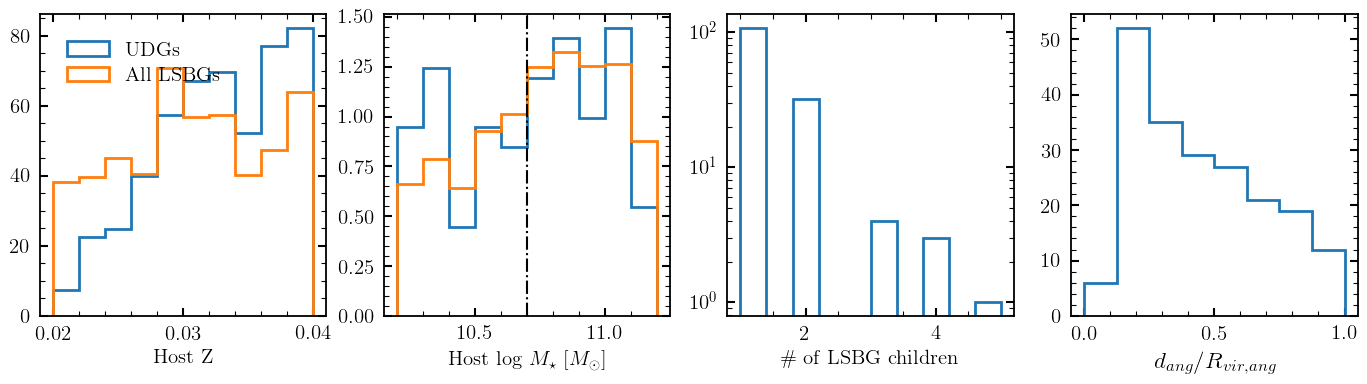

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(17, 4))

plt.sca(axes[0])
plt.hist(udg_cat['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2, density=True, label='UDGs');
plt.hist(cuts_cat['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2, density=True, label='All LSBGs');
plt.xlabel('Host Z')
plt.legend(loc='upper left')

plt.sca(axes[1])
plt.hist(udg_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2, density=True, label='UDGs');
plt.hist(cuts_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2, density=True, label='All LSBGs');
plt.xlabel(r'Host $\log\, M_\star\ [M_\odot]$')
plt.axvline(10.7, c='k', ls='-.')
plt.subplots_adjust(wspace=0.2)

plt.sca(axes[2])
uniques, counts = np.unique(udg_cat['host_name'], return_counts=True)
plt.hist(counts, histtype='step', lw=2)
plt.yscale('log')
plt.xlabel('\# of LSBG children')

plt.sca(axes[3])
lsbg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord)
plt.hist(dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data, 
         range=[0, 1.], bins=8, histtype='step', lw=2);
plt.xlabel(r'$d_{ang} / R_{vir, ang}$', fontsize=17)

### UDG Number as a function of host mass

In [15]:
host_stellar_mass = udg_cat['host_stellar_mass'].data

(array([25., 19., 10., 18., 17., 24., 25., 19., 32., 12.]),
 array([10.21525034, 10.31211666, 10.40898299, 10.50584931, 10.60271563,
        10.69958195, 10.79644827, 10.89331459, 10.99018092, 11.08704724,
        11.18391356]),
 <BarContainer object of 10 artists>)

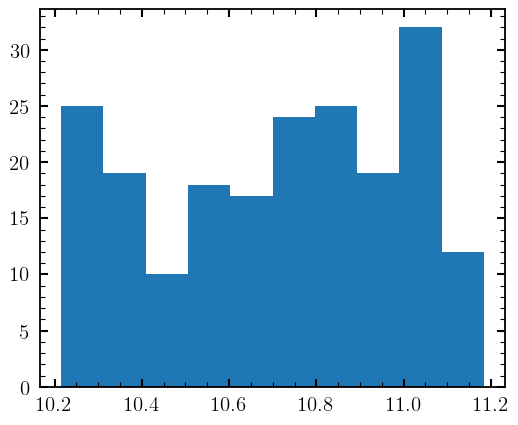

In [16]:
plt.hist(host_stellar_mass)

In [17]:
cuts_cat['is_udg'] = np.in1d(cuts_cat['ID'].data, udg_cat['ID'].data)

In [18]:
from scipy.stats import binned_statistic

In [19]:
res = binned_statistic(cuts_cat['host_halo_mass'].data, 
                 cuts_cat['is_udg'].data, 
                 statistic='mean', bins=5)

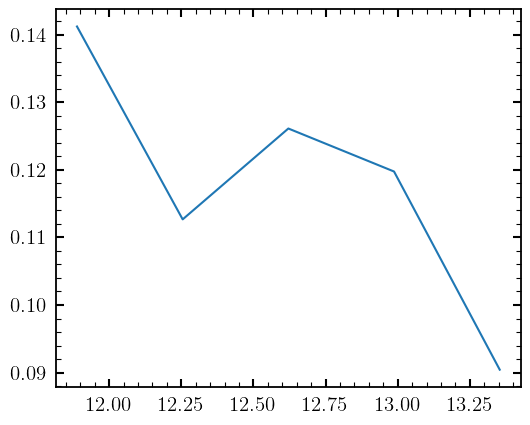

In [20]:
bin_cen = (res.bin_edges[1:] + res.bin_edges[:-1]) / 2

plt.plot(bin_cen, res.statistic)

In [26]:
from colossus.cosmology import cosmology
from colossus.halo import profile_nfw

cosmology.setCosmology('planck15')
p_nfw = profile_nfw.NFWProfile(M=1e11, c=10.0, z=0.0, mdef='vir')

In [27]:
lsbg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord)

dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

In [37]:
weights = 1 / (np.pi * (udg_cat['host_r_vir'].data / 300)**2)

In [66]:
n, bins = np.histogram(dist_ratio * 300, weights=None)

In [67]:
n = n[1:]
bins = bins[1:]
bin_cen = (bins[1:] + bins[:-1]) / 2

In [68]:
res = p_nfw.fit(bin_cen, n, quantity='Sigma', method='leastsq')
res

-------------------------------------------------------------------------------------
Profile fit: Varying 2 / 2 parameters.
Could not find analytical derivative function for quantity Sigma.
Found solution in 20 steps. Best-fit parameters:
Parameter       rhos = 6.34e-02 [3.58e-02 .. 1.12e-01]
Parameter         rs = 2.60e+02 [1.91e+02 .. 3.53e+02]
chi2 / Ndof = 79.0 / 7 = 11.28
-------------------------------------------------------------------------------------


{'fvec': array([-3.40448498,  5.53004066,  1.52774945, -0.74562724, -1.93347117,
         0.60805261, -4.33646621,  3.09434074, -1.19298031]),
 'nfev': 20,
 'fjac': array([[-123.19720558,    0.44559016,    0.37652657,    0.32390626,
            0.28235161,    0.24871633,    0.22098512,    0.19778629,
            0.17814697],
        [ -66.04232501,    5.86840174,    0.2166372 ,    0.33046267,
            0.38850502,    0.41472258,    0.42229305,    0.41882479,
            0.408884  ]]),
 'ipvt': array([2, 1], dtype=int32),
 'qtf': array([4.28350515e-05, 4.52803679e-04]),
 'x_err': array([[3.57661587e-02, 1.90870639e+02],
        [1.12361918e-01, 3.53422909e+02]]),
 'x': array([6.33936447e-02, 2.59726888e+02]),
 'q_fit': array([39.59551502, 30.53004066, 24.52774945, 20.25437276, 17.06652883,
        14.60805261, 12.66353379, 11.09434074,  9.80701969]),
 'chi2': 78.97297062369086,
 'ndof': 7,
 'chi2_ndof': 11.281852946241552}

In [50]:
p_nfw = profile_nfw.NFWProfile(rs=1.50e+02, rhos=5.55e-02, mdef = 'vir')

In [69]:
p_nfw = profile_nfw.NFWProfile(rs=2.60e+02, rhos=6.34e-02, mdef = 'vir')

In [70]:
rs = np.linspace(0.1, 1, 100) * 300
sigmas = p_nfw.surfaceDensity(rs)

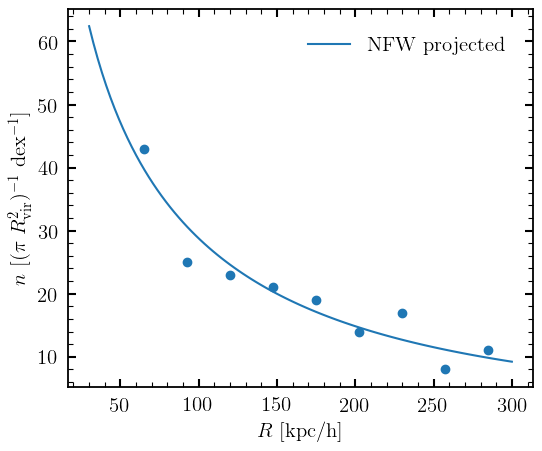

In [71]:
plt.plot(rs, sigmas, label='NFW projected')
plt.scatter(bin_cen, n)

plt.xlabel(r'$R\ [\rm kpc/h]$')
plt.ylabel(r'$n\ [(\pi\ R_{\rm vir}^2)^{-1}\ \rm dex^{-1}]$')

plt.legend()

### Size

In [60]:
range_0 = np.array([np.log10(1.5), np.log10(12)])
edges_0 = np.histogram_bin_edges(np.log10(re_phys), bins=10, range=range_0)


_ns = np.array([np.histogram(np.log10(re_phys), 
                             bins=10, 
                             range=(range_0 + (i/10) * 0.090309))[0] for i in range(-5, 5)])
n_cen = np.nanmean(np.log10(_ns), axis=0)
n_std = np.nanstd(np.log10(_ns), axis=0)

Text(0, 0.5, '$n\\ [\\rm dex^{-1}]$')

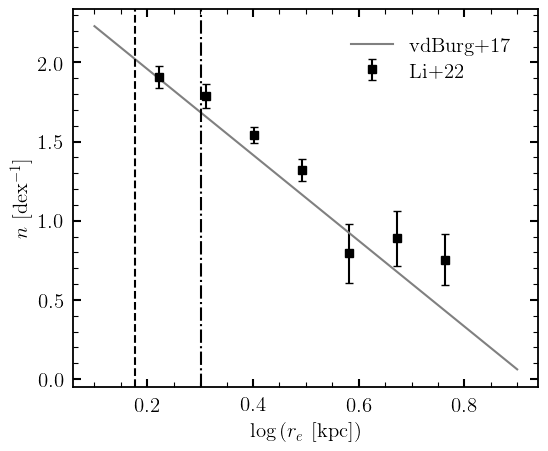

In [94]:
re_phys = udg_cat['rhalf_circularized_phys'].data

# n, bins, _ =  plt.hist(np.log10(re_phys), 
#                        bins=10,
#                        range=(np.log10(1.5), np.log10(12)), 
#                        histtype='step')

bin_cen = (edges_0[:-1] + edges_0[1:]) / 2
plt.errorbar(bin_cen, n_cen, yerr=n_std, fmt='sk', label='Li+22')

x = np.linspace(0.1, 0.9)
plt.plot(x, -2.71 * x + 2.5, color='gray', label='vdBurg+17')
#plt.yscale('log')

plt.axvline(np.log10(1.5), ls='--', color='k')
plt.axvline(np.log10(2.0), ls='-.', color='k')

plt.legend()
#plt.ylim(0, 2)

plt.xlabel(r'$\log\,(r_e\ [\rm kpc])$')
plt.ylabel(r'$n\ [\rm dex^{-1}]$')